In [10]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Full_df read

In [11]:
# read

full_df = pd.read_pickle('../data/processed/full_df.pkl')

full_df.head()

,leg_no,fn_carrier,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,day_of_origin,fn_number_y,ac_registration_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,mingt,flt_event_number,leg,rot_mismatch,actual_block_time,block_delay,ground_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,minute_of_day_dep,Crewchange,act_groundtime_before,sched_groundtime_before,Crewchange_before,rows_to_drop,rows_to_drop_grounddelay
0,272024970,East Carmen Airlines,New Jessica,East Carmen,2019-06-01,2019-06-01 03:25:00,2019-06-01,2019-06-01 06:45:00,2019-06-01 03:50:00,2019-06-01 07:01:00,ECLBAX,other problem,25.0,321,0,0,2019-06-01,EC3292,ECLBAX,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95.0,272024970.0,272022230.0,27.0,NaN,25.0,45.0,1,New Jessica-East Carmen,False,191.0,-9.0,25.0,5,3,6,205,both,94.0,95.0,first flt of day,0,0
1,272022230,East Carmen Airlines,East Carmen,South Nathaniel,2019-06-01,2019-06-01 08:20:00,2019-06-01,2019-06-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,321,60,60,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,45.0,2,East Carmen-South Nathaniel,False,126.0,-9.0,15.0,5,8,10,500,no change,94.0,95.0,both,0,0
2,272212848,East Carmen Airlines,South Nathaniel,East Carmen,2019-06-01,2019-06-01 11:50:00,2019-06-01,2019-06-01 14:15:00,2019-06-01 12:41:00,2019-06-01 14:52:00,ECLBAX,rotational problem,51.0,321,68,75,2019-06-01,EC3258,ECLBAX,South Nathaniel,East Carmen,Joneshaven,2019-06-01 11:50:00,2019-06-01 14:15:00,2019-06-01 15:35:00,2019-06-01 17:00:00,80.0,272212848.0,271997824.0,25.0,NaN,NaN,45.0,3,South Nathaniel-East Carmen,False,131.0,-14.0,51.0,5,11,14,710,both,120.0,75.0,no change,0,0
3,271997824,East Carmen Airlines,East Carmen,Joneshaven,2019-06-01,2019-06-01 15:35:00,2019-06-01,2019-06-01 17:00:00,2019-06-01 16:18:00,2019-06-01 17:32:00,ECLBAX,rotational problem,43.0,321,64,70,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,45.0,4,East Carmen-Joneshaven,False,74.0,-11.0,43.0,5,15,17,935,no change,86.0,80.0,both,0,0
4,271998033,East Carmen Airlines,Joneshaven,East Carmen,2019-06-01,2019-06-01 17:50:00,2019-06-01,2019-06-01 19:10:00,2019-06-01 18:04:00,2019-06-01 19:14:00,ECLBAX,other problem,14.0,321,42,50,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,45.0,5,Joneshaven-East Carmen,False,70.0,-10.0,14.0,5,17,19,1070,last flt of day,32.0,50.0,no change,0,1


# Drop outliers

Generally, we assume that the many unplausible values originate from mistakes arising from data handling and manipulation and not from e.g., scheduling mistakes for negative scheduled groundtime. Consequently, we delete outliers and some negative values *before* we do the train/test split. This might be dangerous if those mistakes are not wrong data. If this would be assumed, one would need to delete them after the train/test split

Focussing on act_groundtime_before and sched_groundtime_before instread of Sched Groundtime and Act Groundtime ensures that we do not drop many last flights of day as they are either NA
or have high values for their respective ground times. This outlier calculation would then filter out the last flights of the day and would not provide an adequate, unskewed forecast.
This worsens the RMSE by 0.1-0.15 Minutes, but it is the more correct approach. 

In [12]:
# Function to identify outliers 
def find_outliers(df, col):
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    iqr = q75 - q25
    limit_lower = q25 - 1.5 * iqr
    limit_upper = q75 + 1.5 * iqr

    outliers = df.index[(df[col] < limit_lower) | (df[col] > limit_upper)]

    return outliers

outlier_idx = []
full_df_columns = full_df[['act_groundtime_before', 'sched_groundtime_before', 'block_delay', 'ground_delay']].columns
for col in full_df_columns:
    if full_df[col].dtype in ['int64', 'float64']:
        outlier_idx.extend(find_outliers(full_df, col))

full_df = full_df.drop(outlier_idx)

# Drop negative ground times
print(full_df.shape)
full_df=full_df[full_df['sched_groundtime_before']>0]
print(full_df.shape)
full_df=full_df[full_df['act_groundtime_before']>0]
print(full_df.shape)

full_df.shape

(9372, 49)
(9357, 49)
(8424, 49)


(8424, 49)

# Create density feature to encode the number of hub departures at the same time

Many flights departing at the same time and the resulting congestion might drive delay times. We encode this using KDE and the resulting density. 

**This improves the RMSE by 0.1, so it is comparatively effective. However, I unfortunately created this after having finished all documents already.** 

Uncomment the next cell to see the improvement.

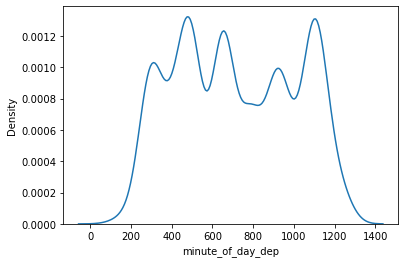

In [13]:
'''
temp = full_df[full_df['arr_leg_inbound']!='East Carmen']

kdes = pd.DataFrame(sns.kdeplot(data=temp['minute_of_day_dep']).lines[0].get_data()).T
kdes.columns=['minute', 'density']
full_df_merged = full_df.merge(kdes, how='cross')

full_df_merged['min_diff']=abs(full_df_merged['minute_of_day_dep']-full_df_merged['minute'])

full_df_merged = full_df_merged.sort_values(by='min_diff').drop_duplicates(subset='leg_no').drop(['minute', 'min_diff'], axis=1)

full_df_merged['density'] = np.where(full_df_merged['arr_leg_inbound']!='East Carmen', full_df_merged['density']*1000, 0)

full_df = full_df_merged
'''

# Drop columns

In [14]:
adv_drop_columns = [
    'leg_no', # identifier
    'fn_number_y', # dupe and no information
    'fn_carrier', # no added information 
    'dep_sched_date', # datetime cannot be handled by some algorithms 
    'dep_sched_time', # datetime cannot be handled by some algorithms 
    'arr_sched_date', # datetime cannot be handled by some algorithms 
    'arr_sched_time', # datetime cannot be handled by some algorithms 
    'm_offblockdt', # datetime cannot be handled by some algorithms 
    'm_onblockdt', # datetime cannot be handled by some algorithms 
    'change_reason_code', # not available at the start of day as it is calculated afterwards
    'dep_delay', # we recalculated this and called it ground_delay
    'day_of_origin', # datetime cannot be handled by some algorithms 
    'ac_registration_y', 
    'dep_leg_inbound', # Same as dep_ap_sched
    'arr_leg_inbound', # This is always East Carmen
    'sched_inbound_dep',
    'sched_inbound_arr',
    'sched_outbound_dep',
    'sched_outbound_arr',
    'leg_inbound',
    'leg_outbound',
    'catering_duration', # little observations
    'cleaning_duration', # little observations
    'pax_boarding_duration', # not available at the start of day as it is calculated afterwards
    'rot_mismatch',
    'rows_to_drop',
    'arr_leg_outbound',
    'mingt', # Todo: Maybe impute as dependent on AC type
    'sched_turnaround', # Todo: Maybe impute
    'trans_time', # not available at the start of day as it is calculated afterwards
    'ground_delay', # not available at the start of day as it is calculated afterwards
    'actual_block_time', # we drop this as we do not know actuals at the beginning of the day and would need another forecast for act block time
    'act_groundtime_before', # we drop this as it is an actual value
    'Crewchange'
]

full_df = full_df.drop(adv_drop_columns, axis = 1)

In [15]:
full_df.head()

,dep_ap_sched,arr_ap_sched,ac_registration_x,Ac Type Code,sched_trans_time,flt_event_number,leg,block_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,minute_of_day_dep,sched_groundtime_before,Crewchange_before,rows_to_drop_grounddelay,density
358178,North Stephenville,East Carmen,ECLBSX,320,50,4,North Stephenville-East Carmen,-12.0,5,21,23,1280,50.0,both,1,0.151768
484978,North Stephenville,East Carmen,ECLBXX,320,50,4,North Stephenville-East Carmen,-11.0,5,21,23,1280,50.0,both,1,0.151768
399978,North Stephenville,East Carmen,ECLBUX,320,50,4,North Stephenville-East Carmen,-3.0,5,21,23,1280,50.0,both,1,0.151768
177378,North Stephenville,East Carmen,ECLBJX,320,50,4,North Stephenville-East Carmen,-9.0,5,21,23,1280,50.0,both,1,0.151768
251978,North Stephenville,East Carmen,ECLBOX,320,50,4,North Stephenville-East Carmen,-20.0,5,21,23,1280,50.0,both,1,0.151768


# Drop all NA

In [16]:
print(full_df.shape)
full_df = full_df.dropna(how = 'any')
print(full_df.shape)

(8424, 16)
(8422, 16)


# Save full_df

In [17]:
full_df.to_pickle('../data/finalized/full_df.pkl')
full_df.shape

(8422, 16)